In [1]:
import os
import warnings

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture

In [2]:
from lcbg.utils import cutout, measure_fwhm
from lcbg.fitting import plot_fit, fit_model, model_subtract

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Local Paths (NB Inputs)

In [5]:
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas_abell370_f105w_v1.0-epoch2_drz.fits"
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz.fits"
#input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_acs-30mas-selfcal_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
#input_data_path = "/Users/rgeda/project/data/lcbg/hlsp_frontier_hst_acs-30mas_abell370/hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz_catalog.csv


# Load Data

In [6]:
hdul = fits.open(input_data_path)
hdu = hdul[0]

In [7]:
data = hdu.data
header = hdu.header
wcs = WCS(header)

In [8]:
#plt.imshow(data, vmin=0, vmax=2.9534784e-05*90)

# Estimate Mean Noise

0.000312165

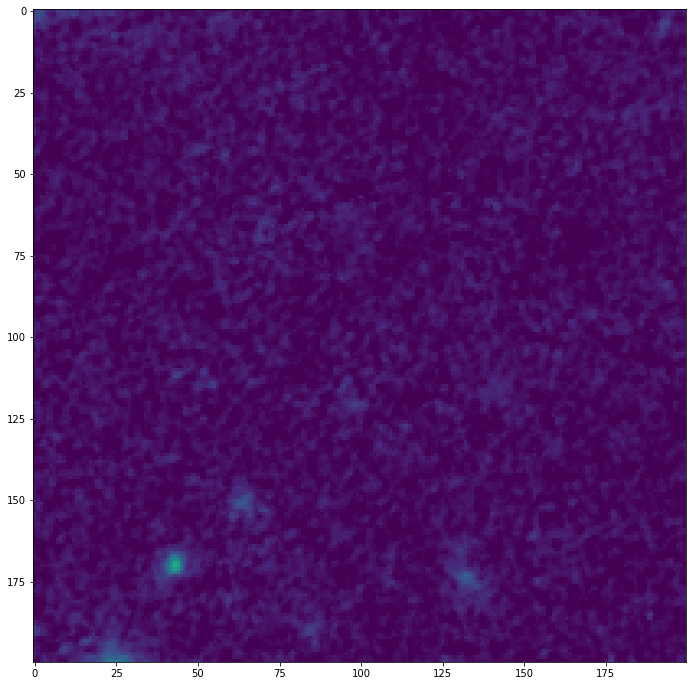

In [9]:
subsection = cutout(data, 4444, 10150, 200)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

In [10]:
mean_noise = subsection.mean()
#mean_noise = data.mean()
mean_noise

0.000312165

# Aperture Photometry

### Select Image

In [11]:
cx, cy = wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])
#image = cutout(data, int(cx), int(cy), 6000)
image = cutout(data, int(cx), int(cy), 4000)

#image = cutout(data,3595, 6377,  2000)
#image = cutout(data, 2072, 8309, 1000)
#image = cutout(data, 3791, 7332, 2000)
#image = data[1000:-1000,1000:-1000]

image -= mean_noise
#mean_noise = image.mean()

In [12]:
"""

from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

gauss = Gaussian2DKernel(x_stddev=int(10*gaussian_fwhm_to_sigma), x_size=8, y_size=8)
gauss.normalize()
gauss *= image.max()

image = convolve_fft(image, gauss)

plt.imshow(image, vmin=0, vmax=vmax)

"""

image = np.clip(image, 0, image.max())


In [13]:
sig8 = np.unique(detect_threshold(image, nsigma=8.))[0]
sig3 = np.unique(detect_threshold(image, nsigma=3.))[0]
sig3, sig8

KeyboardInterrupt: 

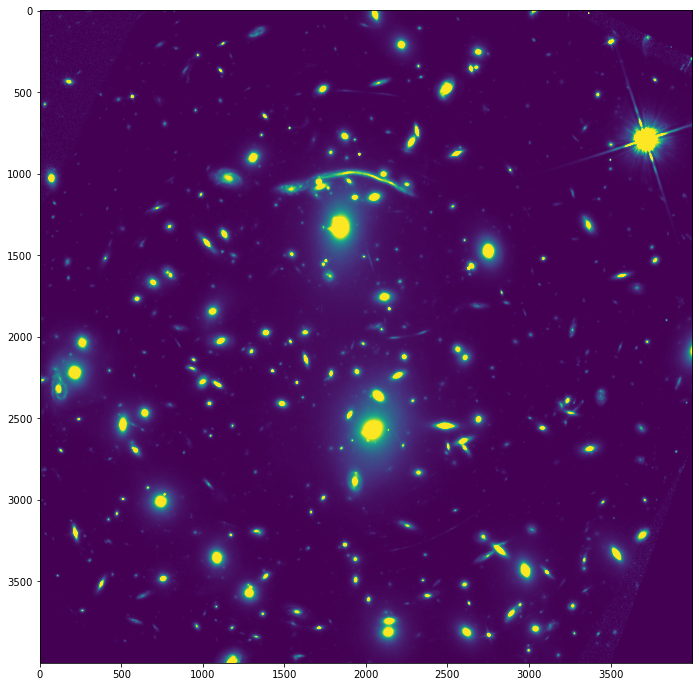

In [14]:
plt.imshow(image, vmin=0, vmax=mean_noise*300)

### Make Segments

In [15]:
def plot_segments(segm, image=None, vmin=None, vmax=None):
    cmap = segm.make_cmap(random_state=np.random.randint(1000000))
    alpha = 1
    if image is not None:
        alpha = 0.5
        plt.imshow(image, vmin=vmin, vmax=vmax, cmap="gist_gray")

    plt.imshow(segm, cmap=cmap, alpha=alpha)

    plt.title('Segmentation Image')
    
def plot_segment_residual(segm, image, vmin=None, vmax=None):
    temp = image.copy()
    temp[np.where(segm.data != 0)] = 0.0
    plt.imshow(temp, vmin=0, vmax=mean_noise*50)

In [16]:
def make_kernel(fwhm, kernel_size):
    sigma = fwhm * gaussian_fwhm_to_sigma  
    kernel = Gaussian2DKernel(sigma, x_size=kernel_size, y_size=kernel_size)
    kernel.normalize()
    return kernel

def make_segments(image, npixels=None, nsigma=3., fwhm=8., kernel_size=4):

    if npixels is None:
        npixels = fwhm**2 
    
    kernel = make_kernel(fwhm, kernel_size) if kernel_size else None 
    
    # Make detection threshold
    if isinstance(nsigma, int):
        threshold = detect_threshold(image, nsigma=nsigma)
    else:
        threshold = nsigma

    
    return detect_sources(image, threshold, npixels=npixels, filter_kernel=kernel,)  
    
def deblend_segments(image, segm, npixels=None, fwhm=8., kernel_size=4, nlevels=30, contrast=1/1000):
    
    if npixels is None:
        npixels = fwhm**2 
        
    kernel = make_kernel(fwhm, kernel_size) if kernel_size else None 

    segm_deblend = deblend_sources(image, segm, 
                                   npixels=npixels, filter_kernel=kernel,
                                   nlevels=nlevels, contrast=contrast)

    return segm_deblend 

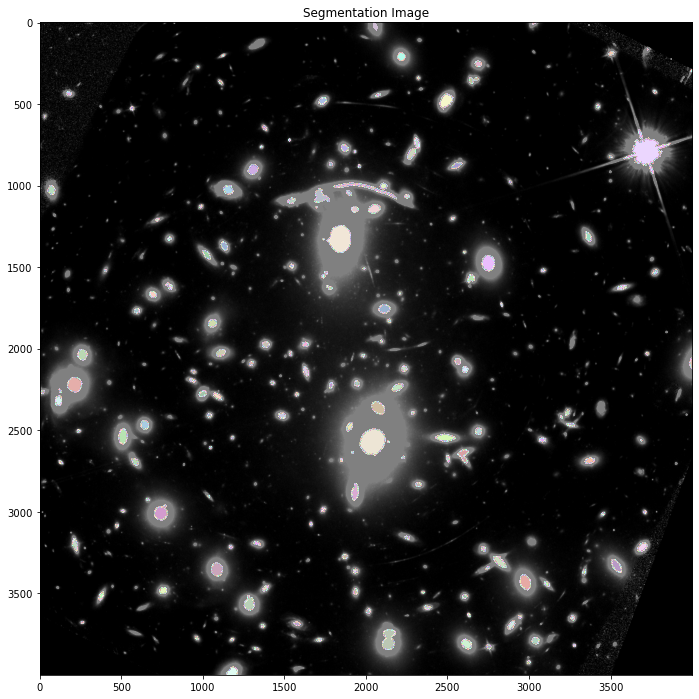

In [17]:
nsigma = np.zeros_like(image) + image.mean()*5
segm = make_segments(image, nsigma=nsigma, kernel_size=None)
plot_segments(segm, image, vmin=0, vmax=mean_noise*50)

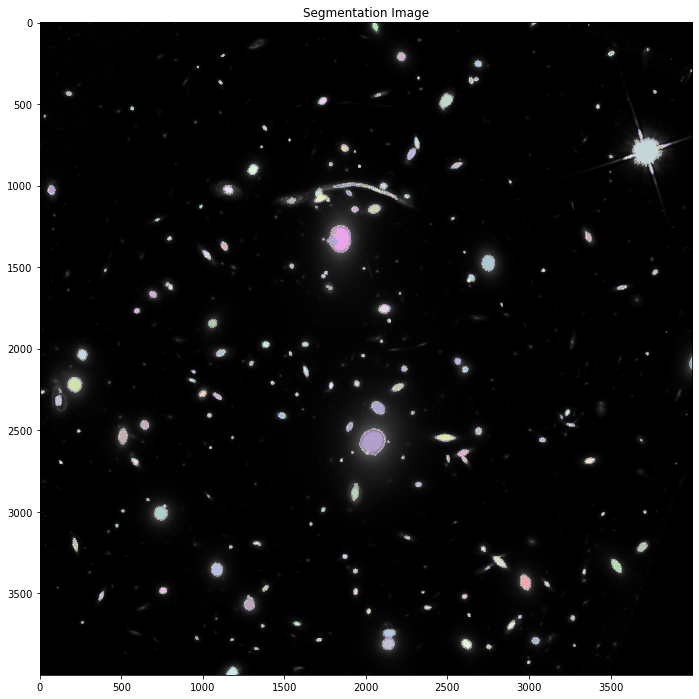

In [18]:
segm_deblend = deblend_segments(image, segm)
plot_segments(segm_deblend, image, vmin=0, vmax=mean_noise*300)

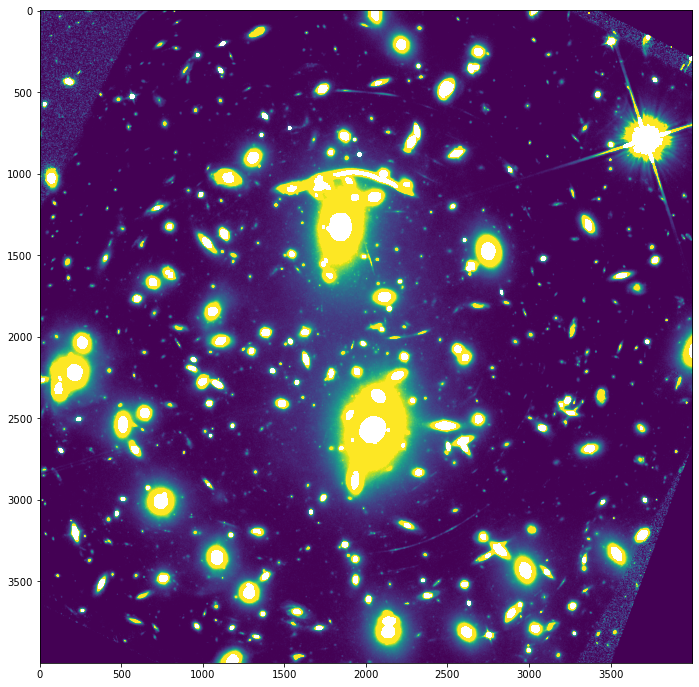

In [19]:
image_residual = image.copy()
image_residual[np.where(segm.data != 0)] = np.nan
plt.imshow(image_residual, vmin=0, vmax=mean_noise*50)

#plot_segment_residual(segm_deblend, image)

In [20]:
segm_deblend.remove_border_labels(50)
len(segm_deblend.segments)

191

### Make Catalog

In [21]:
cat = source_properties(image, segm_deblend, wcs=wcs)

### Make Apertures

In [22]:
def plot_apertures(image, apertures, vmin=None, vmax=None, color='white'):
    norm = ImageNormalize(stretch=SqrtStretch())
    plt.imshow(image, cmap='Greys_r', vmin=vmin, vmax=vmax)
    plt.title('Apertures')
    
    for aperture in apertures:
        aperture.plot(axes=plt.gca(), color=color, lw=1.5)

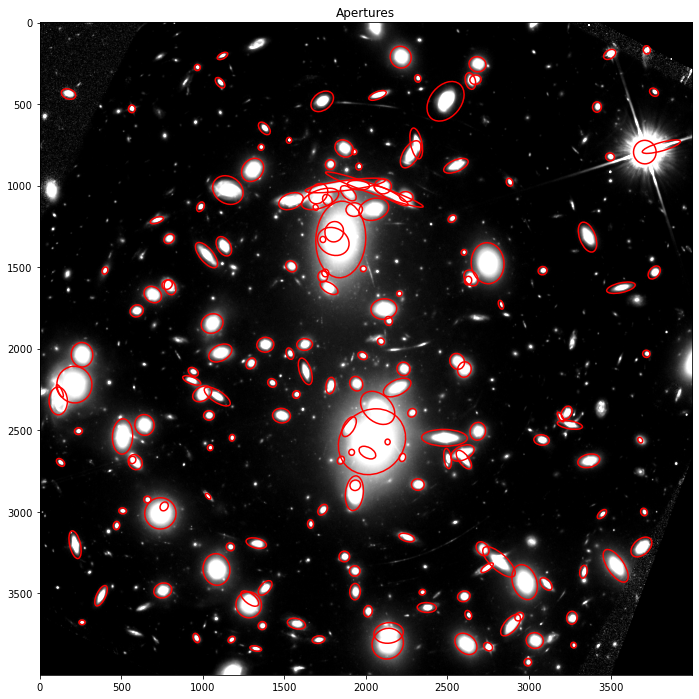

In [23]:
r = 7.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))
    
plot_apertures(image, apertures, vmin=0, vmax=mean_noise*100, color='r')

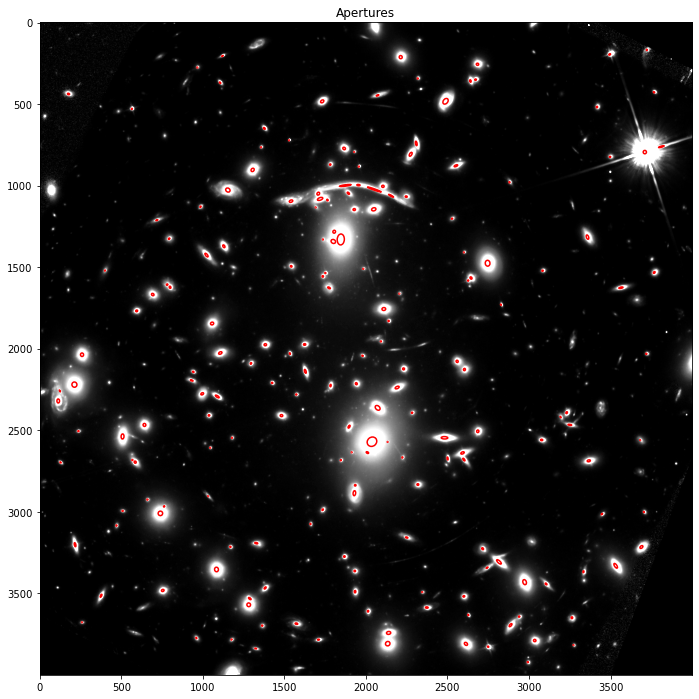

In [25]:
r = 1.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))
    
plot_apertures(image, apertures, vmin=0, vmax=mean_noise*200, color='r')

# Photometry

In [26]:
@custom_model
def Nuker2D(x, y, amplitude=1, r_eff=1, x_0=0, y_0=0, a=1, b=2, g=0, ellip=0, theta=0):
    
    A, B = 1*r_eff, (1 - ellip)*r_eff
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    r = np.sqrt((x_maj / A) ** 2 + (x_min / B) ** 2)
    
    return 2**((b-g)/a)*amplitude*(r_eff/r)**(g)*(1+(r/r_eff)**a)**((g-b)/a)

In [27]:
class Exponential2d(functional_models.Fittable2DModel):
    amplitude = Parameter(default=1)
    r_eff = Parameter(default=1)
    x_0 = Parameter(default=0)
    y_0 = Parameter(default=0)
    ellip = Parameter(default=0)
    theta = Parameter(default=0)
    _gammaincinv = None
    
    @classmethod
    def evaluate(cls, x, y, amplitude, r_eff, x_0, y_0, ellip, theta):
        """Two dimensional Sersic profile function."""

        if cls._gammaincinv is None:
            try:
                from scipy.special import gammaincinv
                cls._gammaincinv = gammaincinv
            except ValueError:
                raise ImportError('Sersic2D model requires scipy > 0.11.')
    
        a, b = r_eff, (1 - ellip) * r_eff
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
        x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
        z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

        return amplitude * np.exp(-z)
    
    @property
    def input_units(self):
        if self.x_0.unit is None:
            return None
        return {'x': self.x_0.unit,
                'y': self.y_0.unit}
    
    def _parameter_units_for_data_units(self, inputs_unit, outputs_unit):
        # Note that here we need to make sure that x and y are in the same
        # units otherwise this can lead to issues since rotation is not well
        # defined.
        if inputs_unit['x'] != inputs_unit['y']:
            raise UnitsError("Units of 'x' and 'y' inputs should match")
        return {'x_0': inputs_unit['x'],
                'y_0': inputs_unit['x'],
                'r_eff': inputs_unit['x'],
                'theta': u.rad,
                'amplitude': outputs_unit['z']}
    

In [48]:
@custom_model
def Moffat2D(x, y, amplitude=1.0, x_0=0.0, y_0=0.0, gamma=1.0, alpha=1.0, ellip=0, theta=0, r=1):
    """Two dimensional Moffat function."""
    
    a, b = 1*r, (1 - ellip)*r
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)
    
    rr_gg = (z) / gamma ** 2
    
    return amplitude * (1 + rr_gg) ** (-alpha)

In [30]:
@custom_model
def Moffat2D(x, y, amplitude=1.0, x_0=0.0, y_0=0.0, gamma=1.0, alpha=1.0):
    """Two dimensional Moffat function."""
    rr_gg = ((x - x_0) ** 2 + (y - y_0) ** 2) / gamma ** 2
    return amplitude * (1 + rr_gg) ** (-alpha)

In [31]:
table = cat.to_table()['area']
order_all = table.argsort()
order_all = list(reversed(order_all))
len(order_all)

191

In [32]:
order = order_all[1:20]

IntProgress(value=0, description='Loading:', max=19)

0


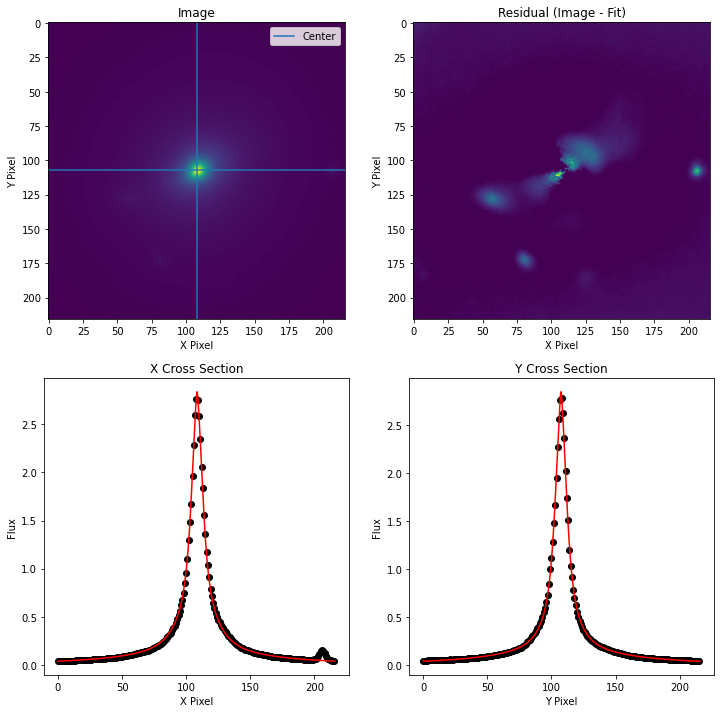

1


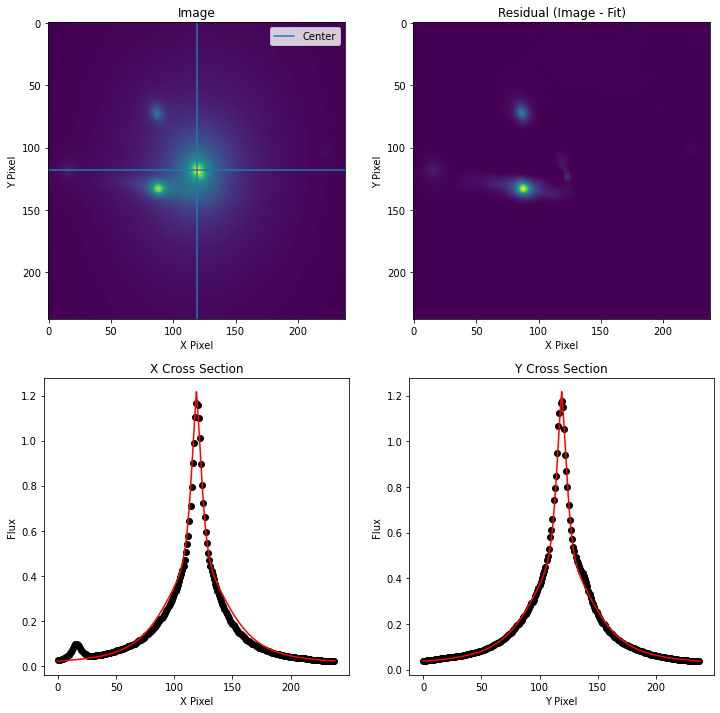

2


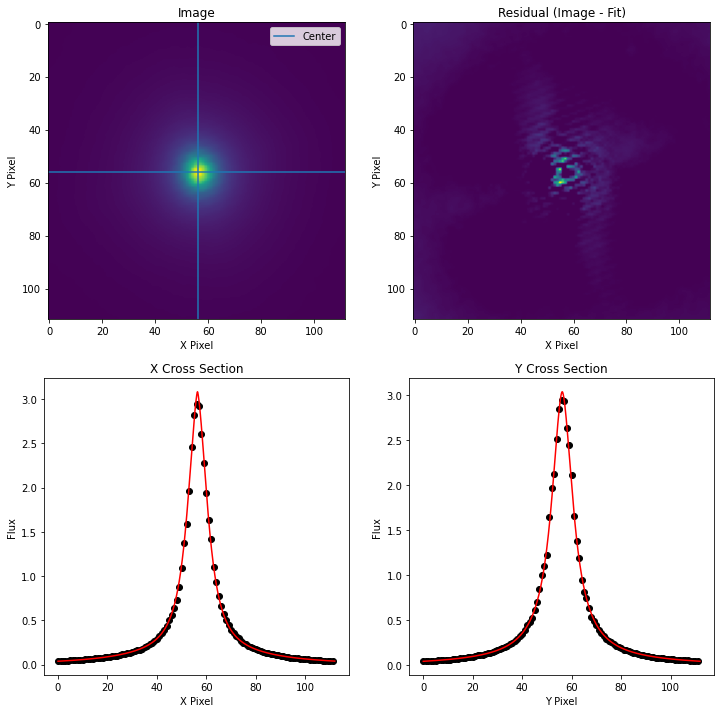

3


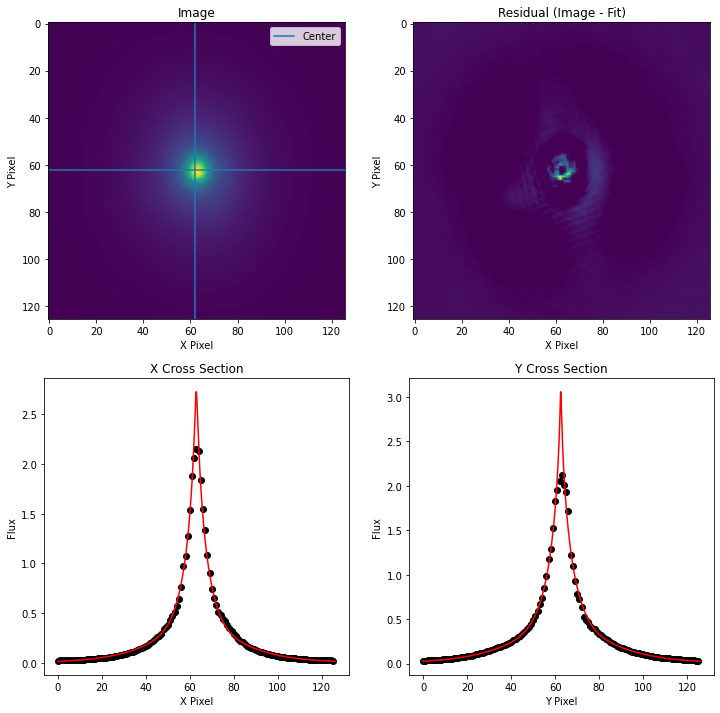

4


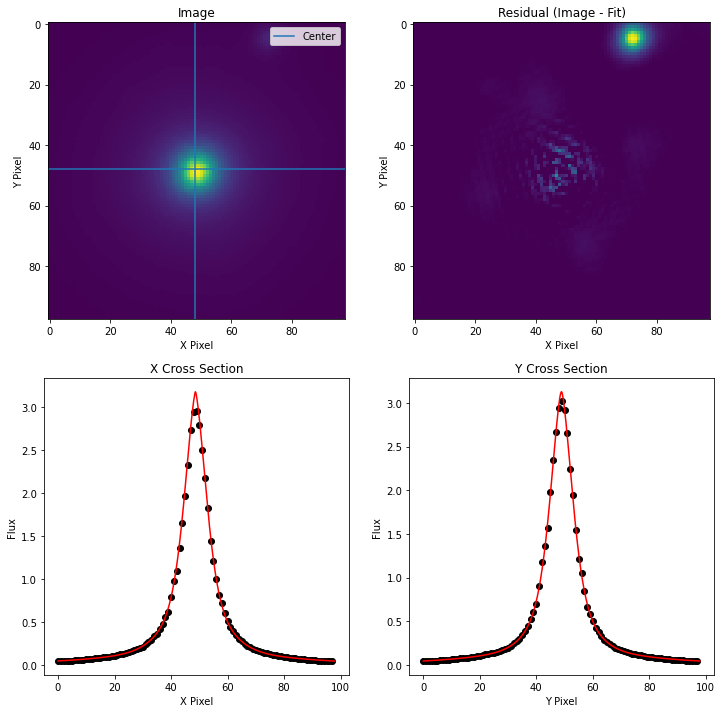

5


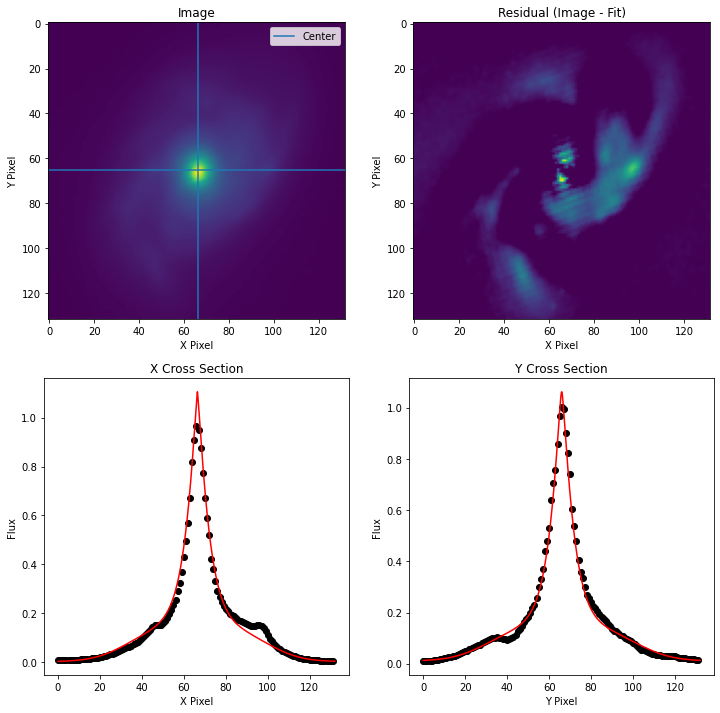

6


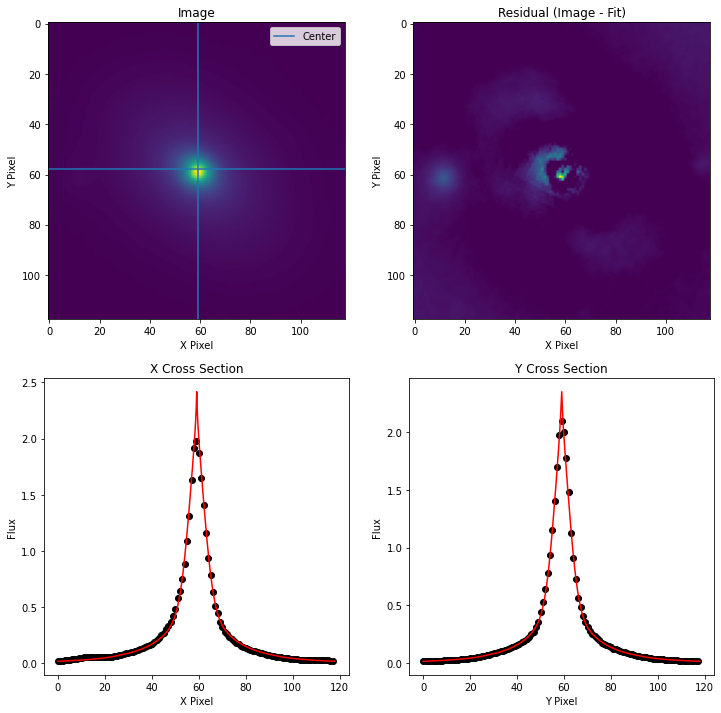

7


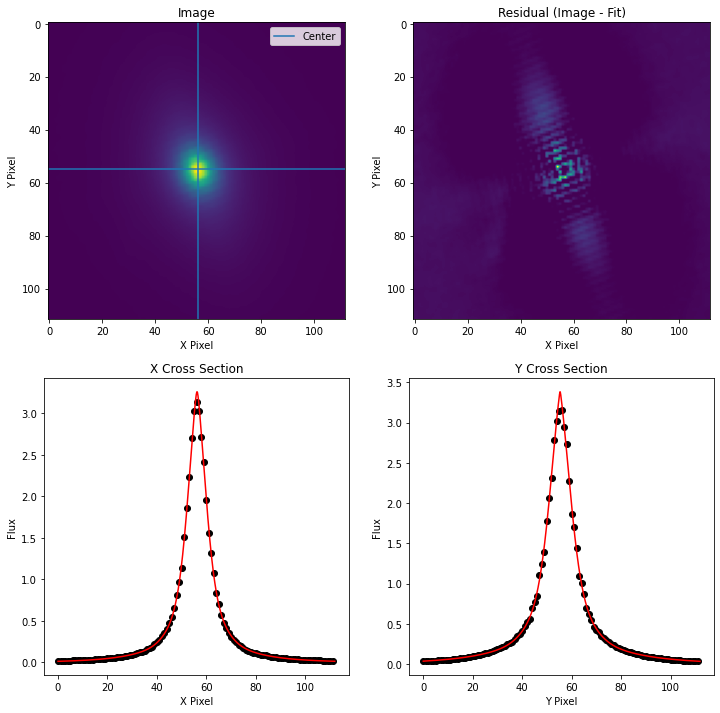

8


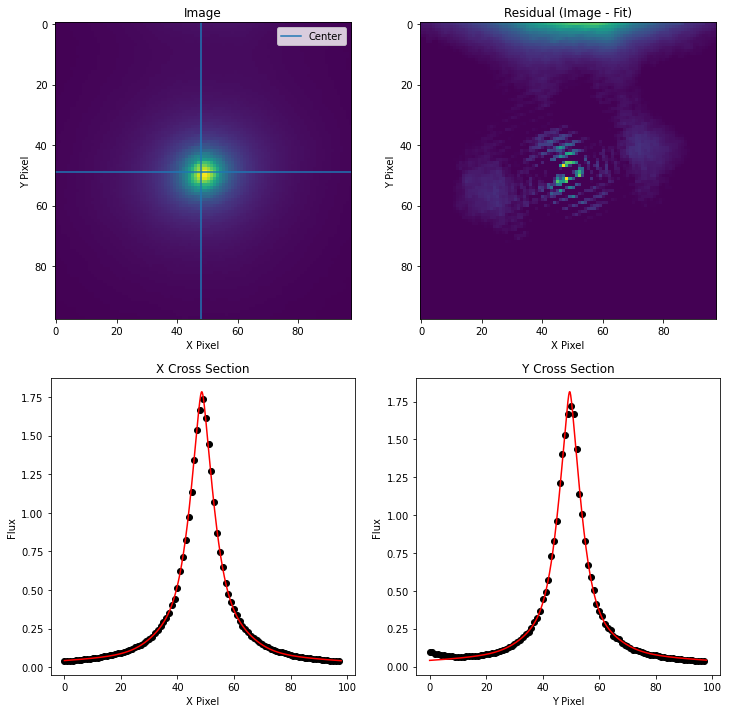

9


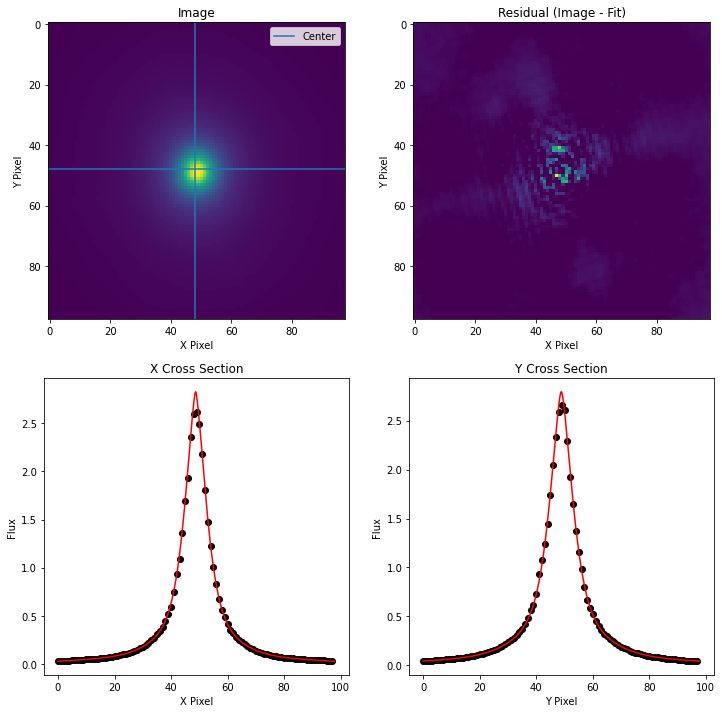

10


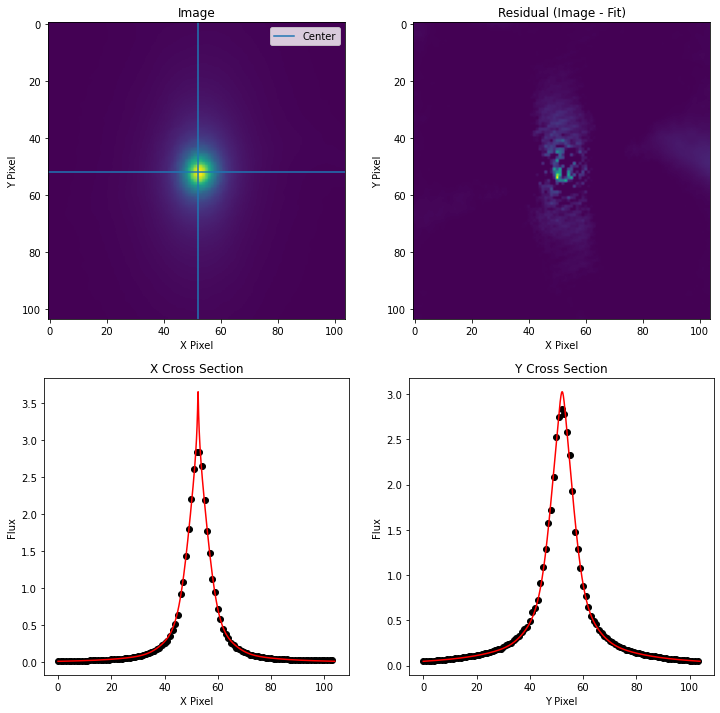

11


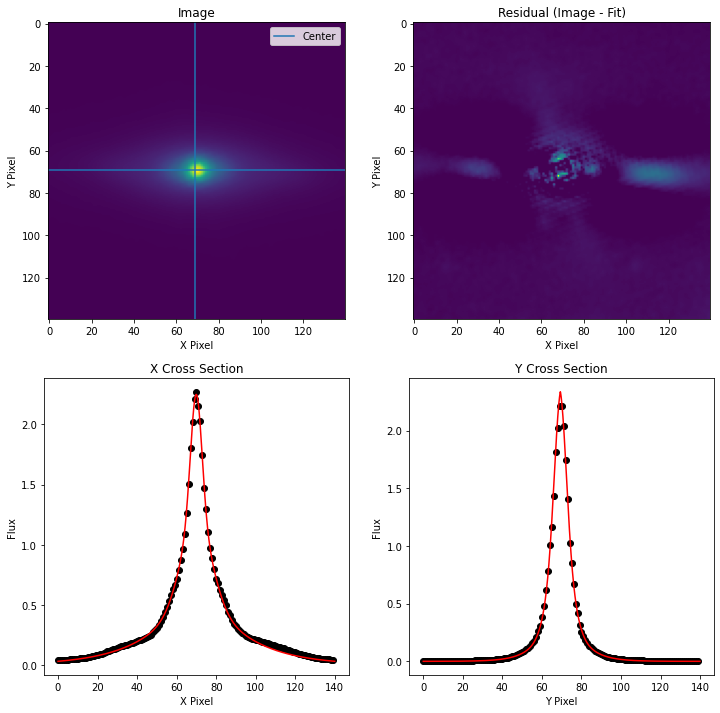

12


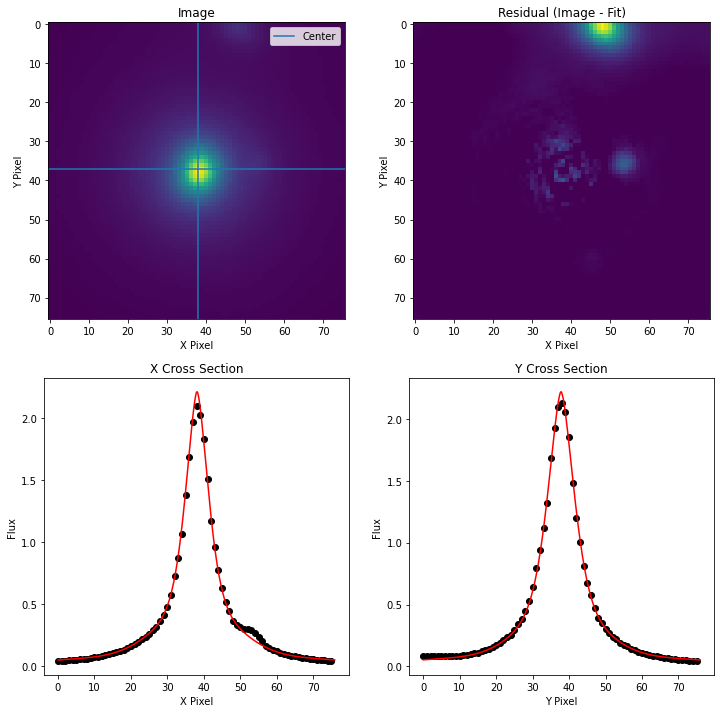

13


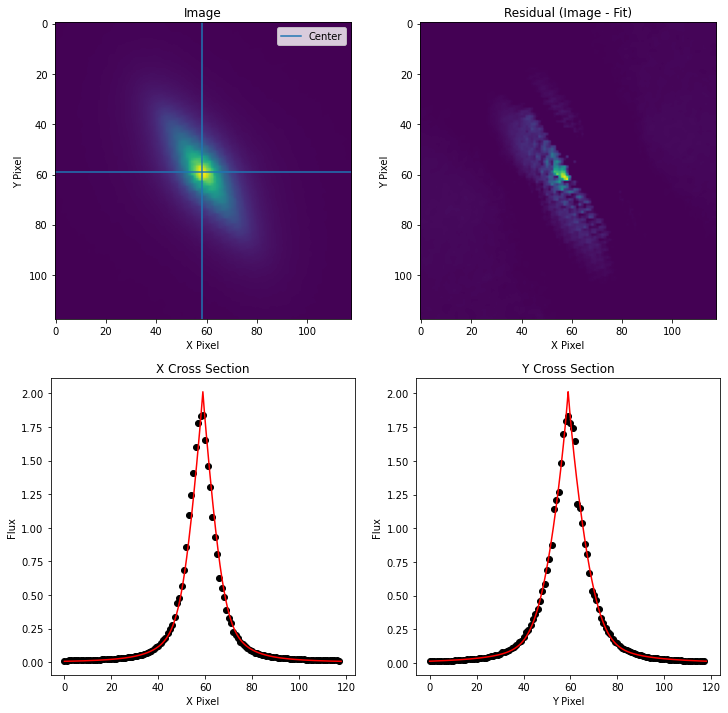

14


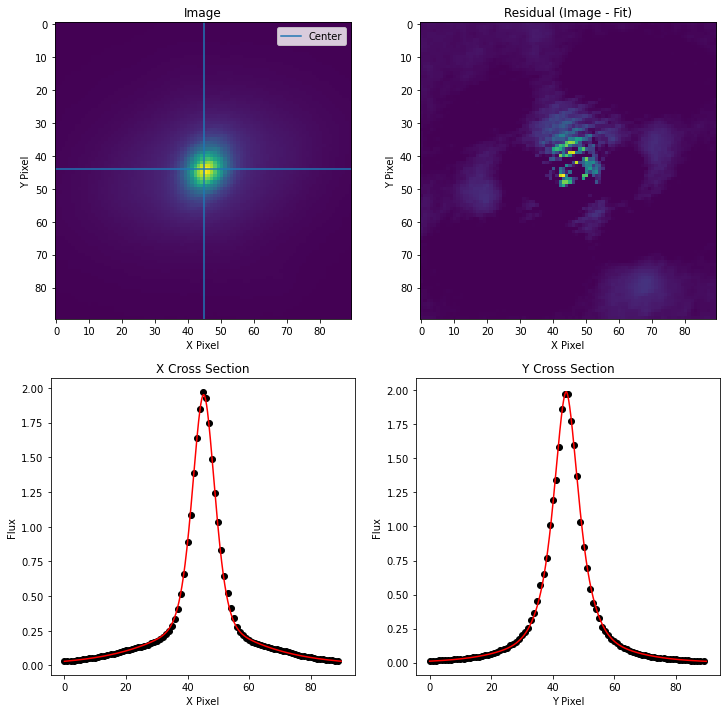

15


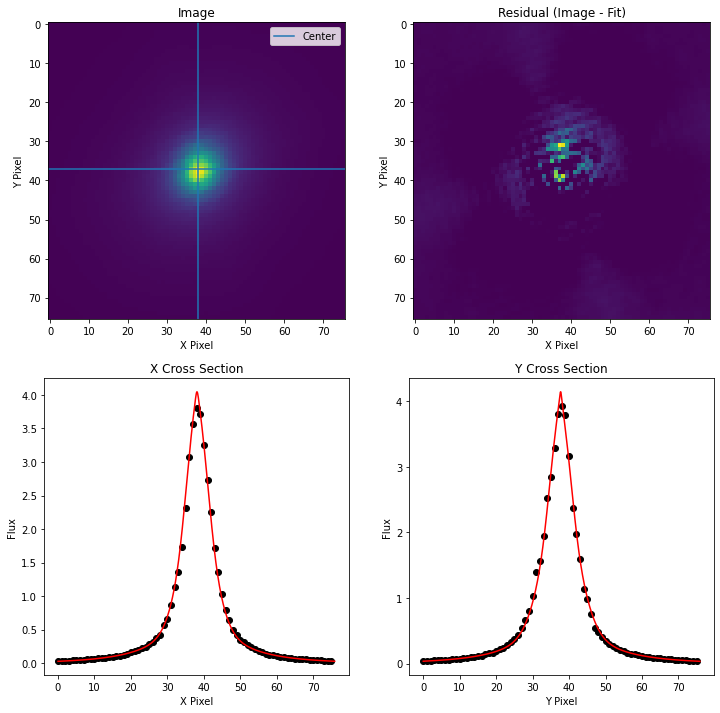

16


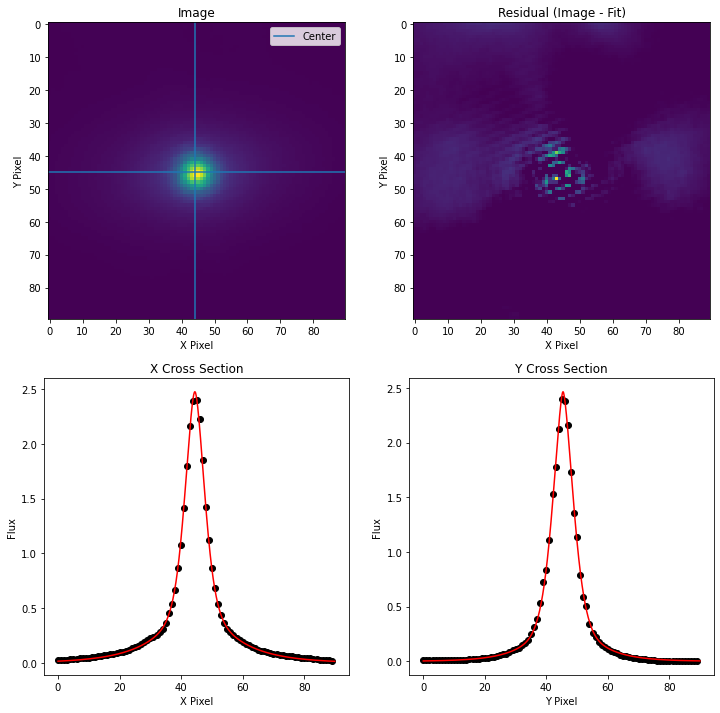

17


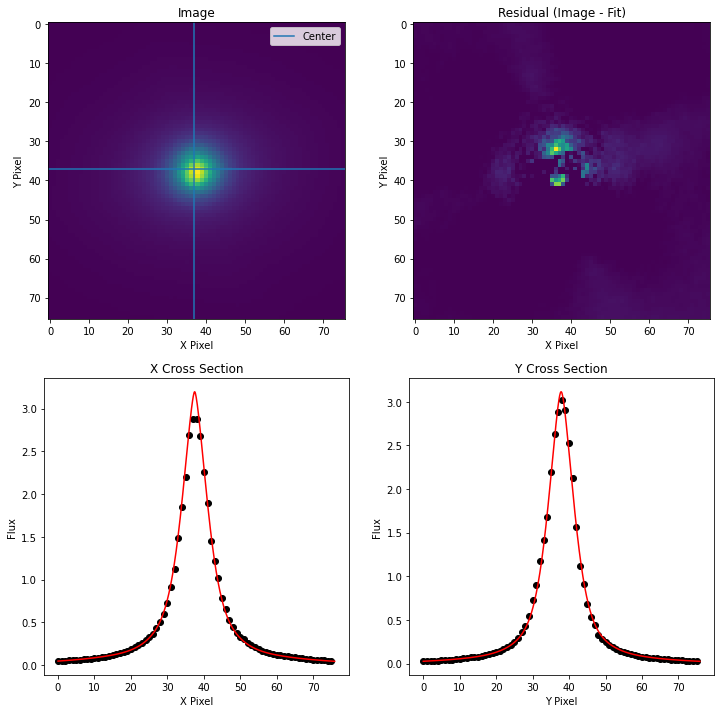

18


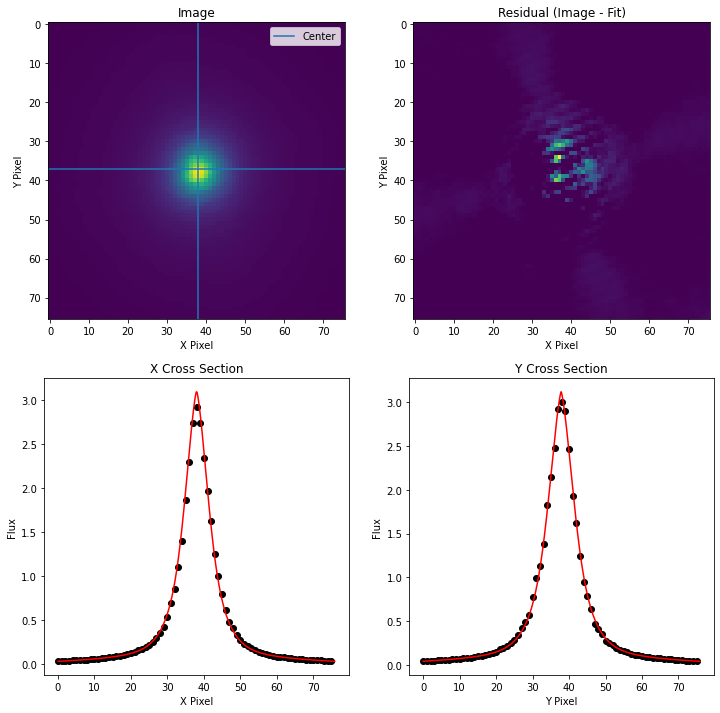

Done


In [33]:
###############
# Photometry #
##############

# Load progress bar
pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(order),
        step=1,
        description='Loading:',
        bar_style='', # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
)

display(pb)

# Copy image for output
image_copy = image.copy()
image_residual_copy = image_residual.copy()
image_zero = np.zeros_like(image_copy) + mean_noise

for i, cat_index in enumerate(order):
    print(i)
    # Update progress bar 
    pb.value = i + 1
    pb.description = "{}/{}".format(pb.value, len(order))
    
    # Load object and aperture 
    obj = cat[cat_index]
    aperture = apertures[cat_index]
    
    #x, y = [int(np.round(pos)) for pos in aperture.positions]
    cut = obj.segment.make_cutout(image, masked_array=True)
    cy, cx = np.unravel_index(cut.argmax(), cut.shape)
    #cy, cx = np.round(obj.centroid.value).astype(int)
    x = obj.segment.bbox.ixmin + cx
    y = obj.segment.bbox.iymin + cy
    
    #amp = obj.max_value
    amp = cut.data.max() #cutout(temp, temp.shape[1]//2, temp.shape[0]//2, 6).mean()
    
    r_inner = int(np.round(obj.semimajor_axis_sigma.value))    
    
    if i < 3:
        r_outter = r_inner * 7
    else:
        r_outter = r_inner * 7
        
    
    # Make images to fit 
    target_zoom = cutout(image_copy, x, y, r_inner)
    target = cutout(image_copy, x, y, r_outter)
    target_residual = cutout(image_residual_copy, x, y, r_outter)
    
    # Fit inner core
    # --------------
    
    # Find center of image 
    y_0, x_0 = np.array(target_zoom.shape) // 2
    
    # Make innter model
    xy_slack = 10
    model_1 = models.Sersic2D(
                amplitude=amp,
                n=2,
                r_eff=r_inner,
                ellip=(1-aperture.b/aperture.a),
                theta=aperture.theta,
                x_0 = x_0,
                y_0 = y_0,
                #fixed={'theta':True, 'ellip':True},
                bounds={
                    'amplitude':(0, None),
                    'r_eff':(0, None),
                     'n':(0, 6),
                    'ellip':(0, 1),
                    'theta':(0, 2*np.pi),
                    'x_0': (x_0-xy_slack, x_0+xy_slack),
                    'y_0': (y_0-xy_slack, y_0+xy_slack),
                })
    
    
    model_1, fit = fit_model(target_zoom, model_1, maxiter=10000, epsilon=1e-40)
    
    # Fit with glow in aperture
    # -------------------------
    
    # Setup first model for fitting
    """
    for pn in model.param_names:
        model.fixed[pn] = True            
    """
    model_1.fixed.update({
        'x_0': True,
        'y_0': True,
    })
    
    del model_1.bounds['x_0']
    del model_1.bounds['y_0']



    # Remove old center and add new center
    y_0, x_0 = np.array(target_zoom.shape) // 2
    
    model_1.x_0 -= x_0
    model_1.y_0 -= y_0

    y_0, x_0 = np.array(target.shape) // 2

    model_1.x_0 += x_0
    model_1.y_0 += y_0
    
    # Setup second model for fitting
    xy_slack = 5
    
    model_2 = models.Sersic2D(
                amplitude=0,
                n=0.1,
                r_eff=model_1.r_eff*3,
                ellip=(1-aperture.b/aperture.a),
                theta=aperture.theta,
                x_0 = model_1.x_0,
                y_0 = model_1.y_0,
                fixed={'x_0': True, 'y_0': True, 'theta':True, 'ellip':True},
                bounds={
                    'amplitude':(0, None),
                    'r_eff':(0, None),
                    'n':(0, 2),
                    'ellip':(0, 1),
                    'theta':(0, 2*np.pi),
                    #'x_0': (x_0-xy_slack, x_0+xy_slack),
                    #'y_0': (y_0-xy_slack, y_0+xy_slack),
                })


    
    
    model_2, fits = fit_model(target_residual, model_2, maxiter=10000, epsilon=1e-40)
    
    '''
    
    model_3 = Nuker2D(
        amplitude=amp,
        x_0=model_1.x_0,
        y_0=model_1.y_0,
        ellip=(1-aperture.b/aperture.a),
        theta=aperture.theta,
        fixed={'x_0': True, 'y_0': True,},
        bounds={
                'amplitude':(0, None),
            'g':(0,None), 
            'ellip':(0, 1), 'theta':(0, np.pi*2),
                #'x_0': (x_0-xy_slack, x_0+xy_slack),
                #'y_0': (y_0-xy_slack, y_0+xy_slack),
            }
    )
    '''
    
    if i < 3:
        model_3 = Moffat2D(
            amplitude=amp,
            x_0=model_1.x_0,
            y_0=model_1.y_0,
            #ellip=(1-aperture.b/aperture.a),
            #theta=aperture.theta,
            fixed={'x_0': True, 'y_0': True,},
            bounds={
                    'amplitude':(0, None),
                #'ellip':(0, 1), 'theta':(0, np.pi*2),
                    #'x_0': (x_0-xy_slack, x_0+xy_slack),
                    #'y_0': (y_0-xy_slack, y_0+xy_slack),
                }
        )
    else:
        model_3 = models.Gaussian2D(
            amplitude=amp,
            x_mean=model_1.x_0,
            y_mean=model_1.y_0,
            x_stddev=model_1.r_eff,
            y_stddev=model_1.r_eff,
            fixed={'x_mean': True, 'y_mean': True,}
        )
        
                
    model_3, fits = fit_model(target, model_3, maxiter=10000, epsilon=1e-40)
    
    # Combine models
    model = model_1 + model_2 + model_3
    
    # Fit combined model
    model, fit = fit_model(target, model, maxiter=10000, epsilon=1e-40)
    model, fit = fit_model(target, model, maxiter=10000, epsilon=1e-40)
    
    # Make center of model the center of model_1 
    model.x_0 = model_1.x_0
    model.y_0 = model_1.y_0
    
    # Plot and Print
    # --------------
    
    fig, ax = plot_fit(target, model)#, vmin=vmin, vmax=vmax)
    
    """
    
    position = np.transpose((model.x_0, model.y_0))
    a, b = model.r_eff_0.value, (1 - model.ellip_0.value) * model.r_eff_0.value
    theta = model.theta_0.value
    app = EllipticalAperture(position, a, b, theta=theta)
    app.plot(axes=ax[0], color='white', lw=1.5)
    app.plot(axes=ax[1], color='white', lw=1.5)
    
    position = np.transpose((model.x_0, model.y_0))
    a, b = model.r_eff_1.value, (1 - model.ellip_1.value) * model.r_eff_1.value
    theta = model.theta_1.value
    app = EllipticalAperture(position, a, b, theta=theta)
    app.plot(axes=ax[0], color='white', lw=1.5)
    app.plot(axes=ax[1], color='white', lw=1.5)
    
    position = np.transpose((model.x_0, model.y_0))
    a, b = aperture.a , aperture.b
    theta = aperture.theta
    app = EllipticalAperture(position, a, b, theta=theta)
    app.plot(axes=ax[0], color='white', lw=1.5, linestyle='--')
    app.plot(axes=ax[1], color='white', lw=1.5, linestyle='--')
    """
    
    plt.show()
    
    #print("\n".join([str(j) for j in zip(model.param_names, model.parameters)]))
    #print("\n"*3)
    
    # Subtract from image
    # -------------------
    
    if fit.fit_info['ierr'] > 4:
        continue
    
    # Make new image
    size = r_inner * 20 #int(np.clip(np.ceil(model.r_eff_1*8), 0, 500))
    y_arange, x_arange = np.mgrid[
        int(model.y_0.value)-size:int(model.y_0.value)+size,
        int(model.x_0.value)-size:int(model.x_0.value)+size, ]
    model_image = model(x_arange, y_arange)
    
    # Subtract cutout from main copy image
    image_copy = model_subtract(image_copy, np.array(model_image), x, y)
    image_copy[y-8:y+8, x-8:x+8] = 0. #image_copy[y-80:y+80, x-80:x+80].mean()
    #image_copy = abs(image_copy) 
    image_copy = np.clip(image_copy, 0, image_copy.max())
    
    # Add cutout to main cutout only image 
    image_zero = model_subtract(image_zero, -1*np.array(model_image), x, y)
    
    # Subtract cutout second component from residual image 
    image_residual_copy = model_subtract(image_residual_copy, np.array(model_image), x, y)
    
print("Done")


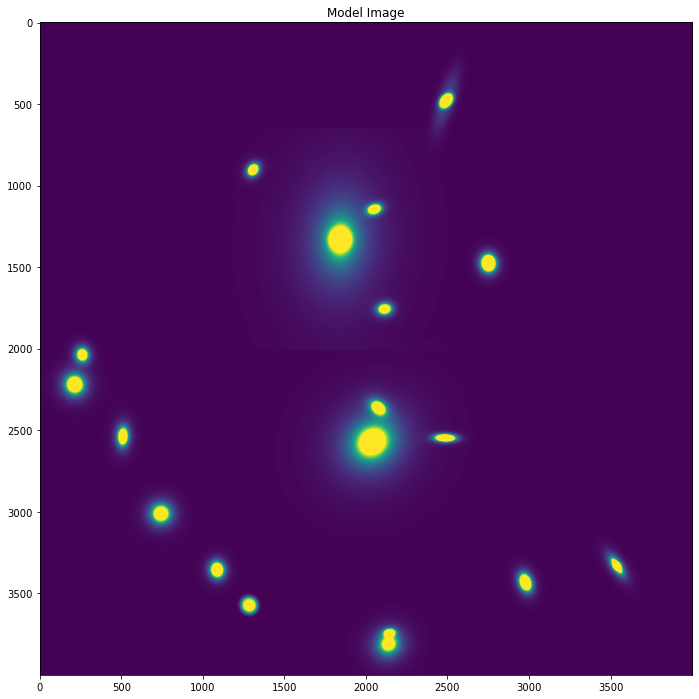

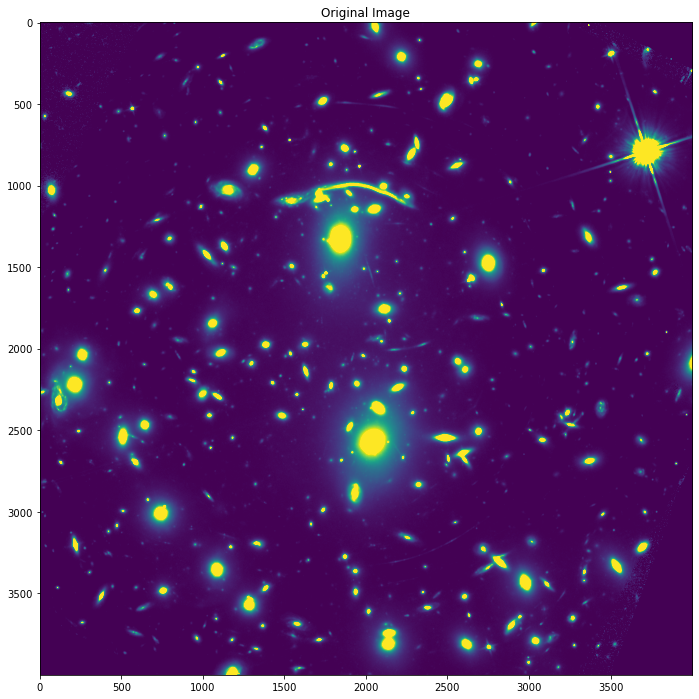

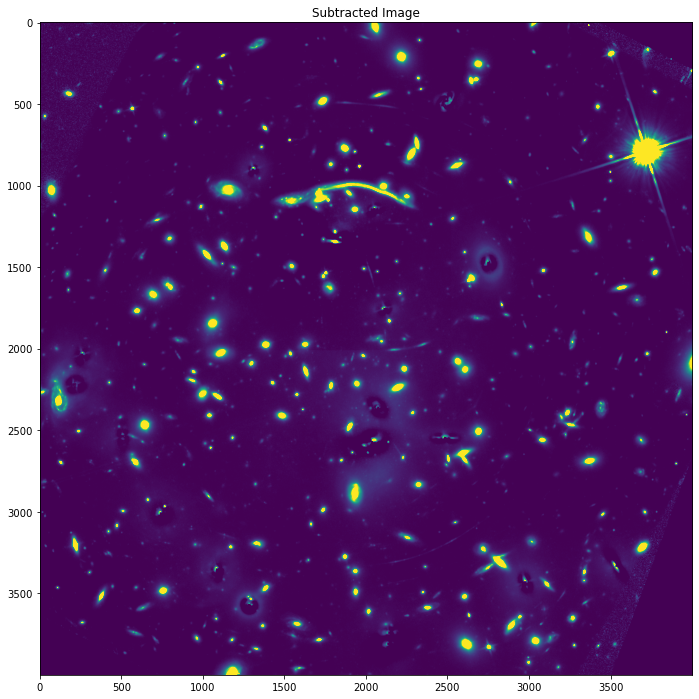

In [158]:
vmax = mean_noise*200
vmin = 0#np.unique(threshold)[0]
plt.imshow(image_zero, vmin=vmin, vmax=vmax)
plt.title("Model Image")
plt.show()

plt.imshow(image, vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.show()

plt.imshow(image_copy, vmin=vmin, vmax=vmax)
plt.title("Subtracted Image")
plt.show()

# Do AP on subtracted image 

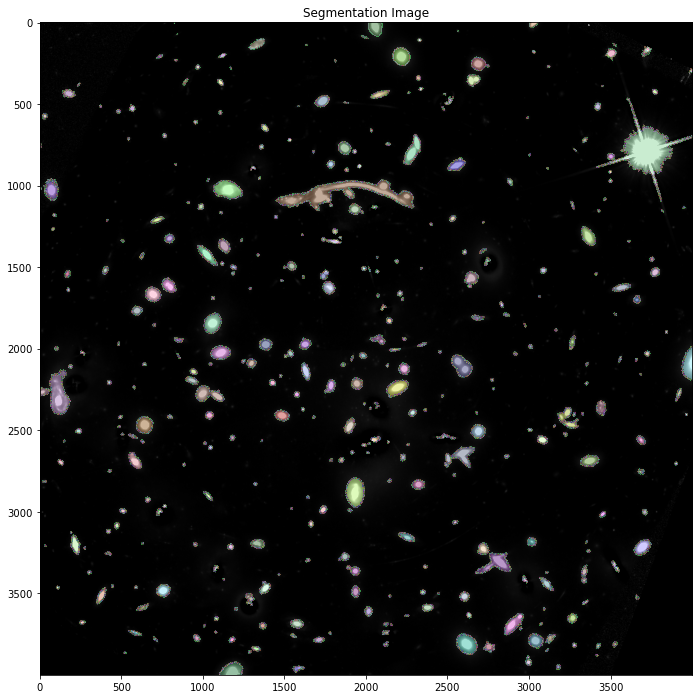

In [162]:
nsigma = np.zeros_like(image) + image.mean()
segm = make_segments(image_copy, nsigma=nsigma, kernel_size=None)
plot_segments(segm, image_copy, vmin=0, vmax=mean_noise*200)

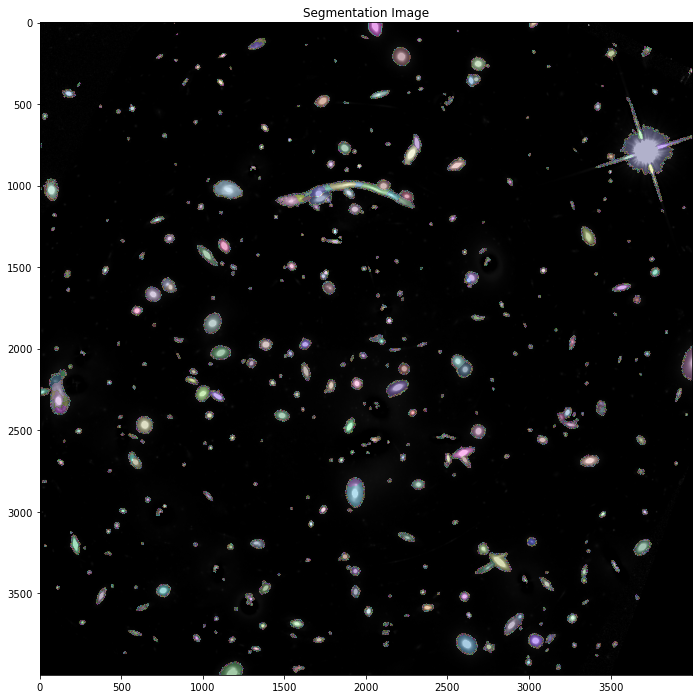

In [163]:
segm_deblend = deblend_segments(image_copy, segm)
plot_segments(segm_deblend, image_copy, vmin=0, vmax=mean_noise*300)

In [164]:
segm_deblend.remove_border_labels(50)
print(len(segm_deblend.segments))
cat = source_properties(image, segm_deblend, wcs=wcs)

436


In [165]:
r = 4.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

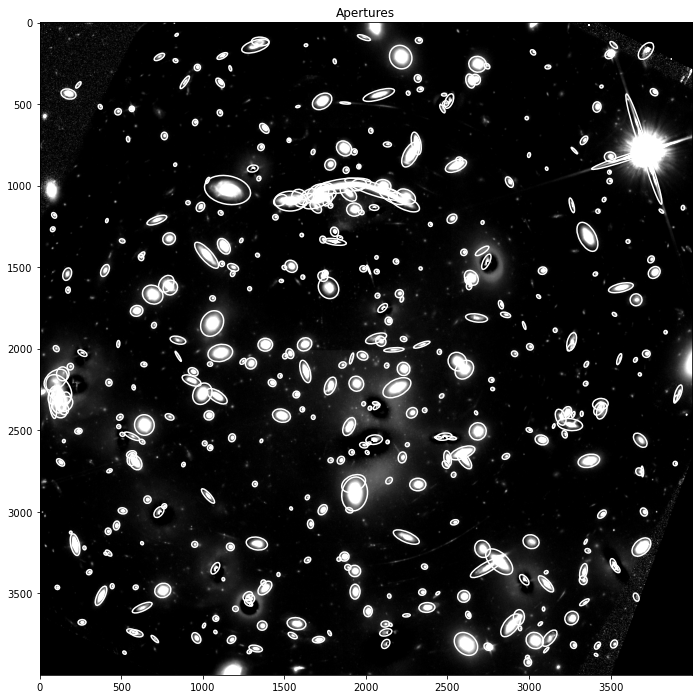

In [166]:
plot_apertures(image_copy, apertures, vmin=0, vmax=mean_noise*100)

In [77]:
aperture_photometry_results = []
for aperture in apertures:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])

In [78]:
table = cat.to_table()
table['aperture_sum'] = np.array(aperture_photometry_results)
table.sort('aperture_sum', reverse=True)

In [79]:
table

<QTable length=447>
  id      xcentroid      ...         gini           aperture_sum   
             pix         ...                                       
int64      float64       ...       float64            float64      
----- ------------------ ... ------------------- ------------------
  365 3668.0906088054967 ... 0.43765610611453243 105848.24119941004
  368  3751.586889652122 ... 0.46580608938935886 103510.36473672869
  367  3580.212010878572 ...  0.4528349122555986   103176.169343797
  443  2049.655052815218 ...  0.2609452010604773 1350.0959957955433
  374 1873.9984886277193 ...   0.313703668390326 1039.4347445425838
  376 2051.1706586553246 ...  0.3206327262552794 1030.6376394781337
  378  1712.788149197366 ...  0.5364218443509401 1000.5373815493322
  382 1715.3770978008715 ... 0.42058037498782297  970.3138869988024
  152 259.14057937109186 ...  0.6198514306369489   962.249824175697
  ...                ... ...                 ...                ...
  181  3679.311596256896 ... 0.11352682392763762 2.8934421987015186
  289   403.709428196844 ... 0.09184671087400212 2.8786587938994224
   10 1632.2478564918308 ... 0.11934370021425446 2.8348489153942316
    6   839.082828051226 ... 0.15917073198729545  2.736987318671728
  233 147.50629856520354 ...  0.0812852097595267 2.7115748016516674
   29 3444.2824669698057 ... 0.09924107198798278 2.6811421760375556
  274 190.01218507742908 ...  0.2289887265872734   2.66551055526293
  281  627.1052952180614 ... 0.09549424710483592 2.6450032295948014
  265 1541.1677387194193 ... 0.12308514678392467   2.62705333214516
  353 3411.2888715729273 ... 0.17891402158042685 2.5700638510093468

In [ ]:
table.write(output_path, format="ascii.csv", overwrite=True)

# End








.

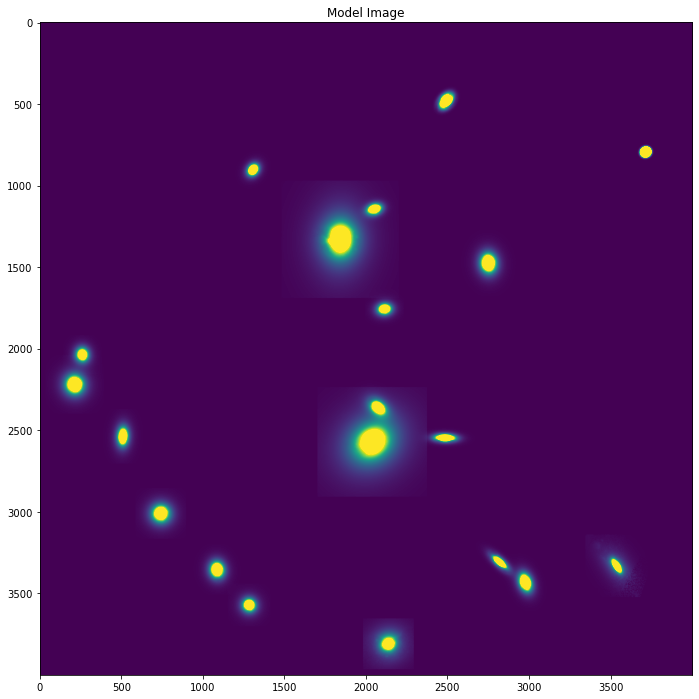

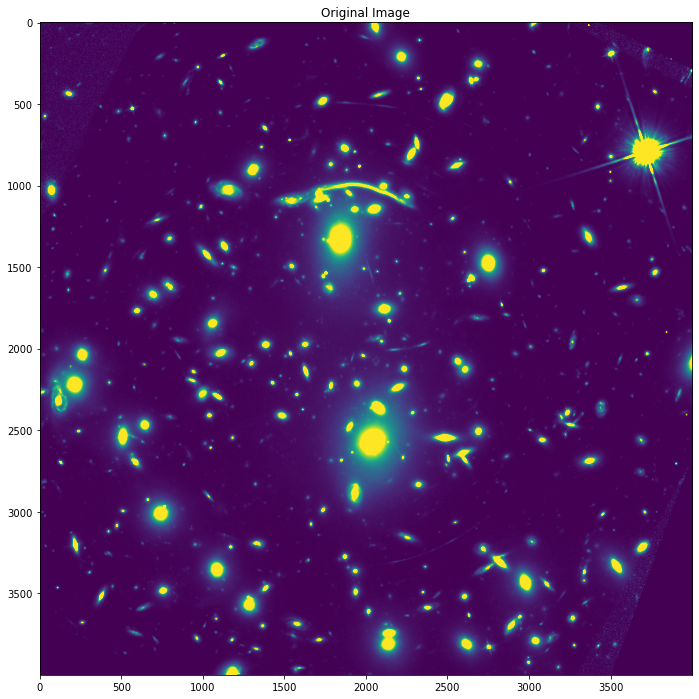

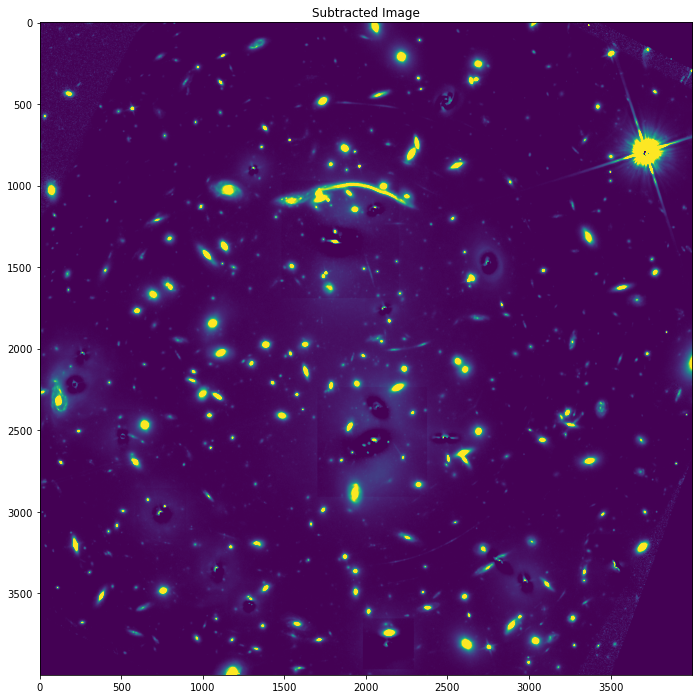

In [1256]:
vmax = mean_noise*200
vmin = 0#np.unique(threshold)[0]
plt.imshow(image-image_copy, vmin=vmin, vmax=vmax)
plt.title("Model Image")
plt.show()


plt.imshow(image, vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.show()

plt.imshow(image_copy, vmin=vmin, vmax=vmax)
plt.title("Subtracted Image")
plt.show()

In [48]:
aperture_photometry_results = []
for aperture in apertures[len(order):]:
    aperture_photometry_results.append(aperture_photometry(image_copy, aperture)['aperture_sum'][0])
    
a2 = np.array(aperture_photometry_results)

In [49]:
aperture_photometry_results = []
for aperture in apertures[len(order):]:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])
    
a1 = np.array(aperture_photometry_results)

In [52]:
np.round(100*(a1-a2)/a1, 2).astype(int)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 88,  0, 94, 96,  0,  0,  0,  0,
       82,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  7, 85,  0,  1, 97, 14,  0, 23,  0,  0,  0,  0, 41,  0,  0,
        0, 41,  0, 94,  0,  0,  0,  8,  0,  0,  5,  0,  0,  0,  0,  0,  0,
        0, 81, 28,  0, 73,  0,  0,  0, 85,  0,  0,  2,  3, 27,  0, 96,  8,
        6,  0,  0, 11, 30,  0, 26,  4,  0,  0, 15,  0,  0, 24,  0, 20,  8,
       16, 24,  0,  0,  0,  0,  5, 18,  0,  0,  0,  9,  0, 96,  0,  0,  0,
        0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0, 97,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  2, 35,  0,  0,  0,  0,  5,  0,  2,  0,  1,  5,  0,  0,
        0,  0,  7, 54, 96, 80,  4, 18, 19,  0,  0,  0,  0,  0,  0, 23, 13,
        0, 17,  0,  0, 64,  0,  0,  0, 98, 95, 65,  0,  0,  0, 93, 92, 98,
       95,  0,  2, 75,  0, 97, 46, 92,  0, 66, 89, 34,  0,  0, 33, 34,  0,
        0,  0,  1,  0, 32

<BarContainer object of 10 artists>

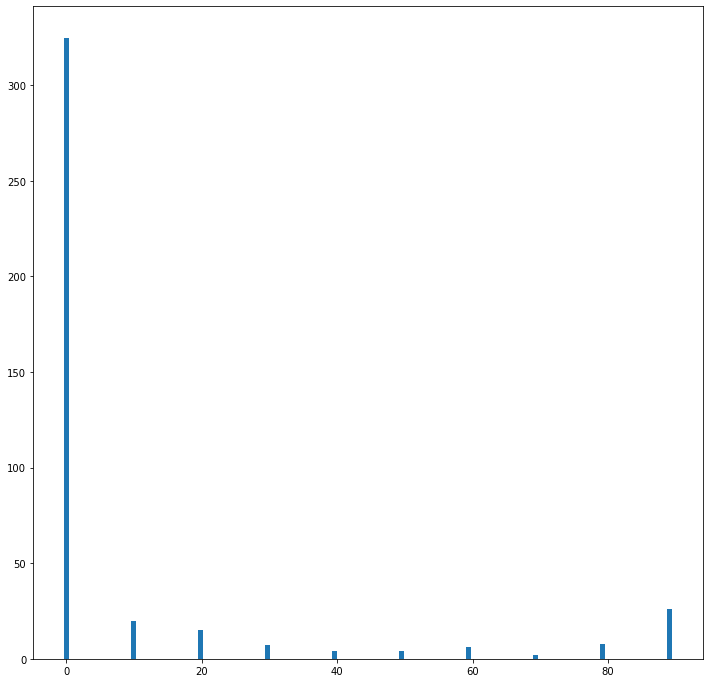

In [53]:
xh, yh = np.histogram(np.round(100*(a1-a2)/a1))
plt.bar(yh[:-1], xh)

In [54]:
a1[1], a2[1]

(66.26457508564206, 66.26457508564206)

# Save Catalog

In [24]:
table = cat.to_table()
table['aperture_sum'] = np.array(aperture_photometry_results)

In [25]:
table.write(output_path, format="ascii.csv", overwrite=True)